In [1]:
import pystan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
data = pd.read_csv('./afl.csv')

In [3]:
data.head()
data['Date'] = pd.to_datetime(data['Date'])

In [4]:
# Discard draws
data = data[data['Home Score'] != data['Away Score']]

data.head()

,Date,Kick Off (local),Home Team,Away Team,Venue,Home Score,Away Score,Play Off Game?,Home Goals,Home Behinds,...,Total Score Close,Total Score Over Open,Total Score Over Min,Total Score Over Max,Total Score Over Close,Total Score Under Open,Total Score Under Min,Total Score Under Max,Total Score Under Close,Notes
0,2018-08-19,16:10,Adelaide,North Melbourne,Adelaide Oval,86,77,NaN,12,14,...,186.5,1.9,1.9,1.9,1.9,1.9,1.9,1.9,1.9,NaN
1,2018-08-19,13:20,West Coast,Melbourne,Optus Stadium,91,108,NaN,14,7,...,173.5,1.9,1.9,1.9,1.9,1.9,1.9,1.9,1.9,NaN
2,2018-08-19,13:10,Carlton,Western Bulldogs,Etihad Stadium,49,66,NaN,7,7,...,171.5,1.9,1.9,1.9,1.9,1.9,1.9,1.9,1.9,NaN
3,2018-08-18,19:25,Gold Coast,Brisbane,Metricon Stadium,74,78,NaN,11,8,...,177.5,1.9,1.9,1.9,1.9,1.9,1.9,1.9,1.9,NaN
4,2018-08-18,19:25,St Kilda,Hawthorn,Etihad Stadium,76,80,NaN,11,10,...,175.5,1.9,1.9,1.9,1.9,1.9,1.9,1.9,1.9,NaN


In [5]:
data = data[data['Date'].dt.year >= 2014]

data.shape

(1009, 52)

In [6]:
# Let's look at who plays at home
counts = data.groupby('Home Team')['Venue'].value_counts()
home_venues = counts[counts > 3]

home_venues

In [7]:
def is_truly_home(row):
    
    home = row['Home Team']
    away = row['Away Team']
    venue = row['Venue']
    
    really_home = venue in home_venues.loc[home] and venue not in home_venues.loc[away]
    
    return really_home

In [8]:
truly_home = data.apply(is_truly_home, axis=1)

In [9]:
model_code = """
data {
    int<lower=1> N; // Number of matches
    int<lower=1> J; // Number of teams
    int<lower=1> K; // Number of seasons
    
    int home_id[N]; // Home team ID
    int away_id[N]; // Away team ID
    
    int season[N]; // Season number for each match
    int home_won[N]; // Whether or not home team won
    
    vector[N] home_mask; // Whether there was a home team or not
}
parameters {
    matrix[K, J] team_skills;
    vector[J] home_advantages;
    
    real home_ad_mean;
    real<lower=0> home_ad_var;
}
model {
    vector[N] home_skills;
    vector[N] away_skills;
    vector[N] home_bonuses;
    
    home_bonuses = home_advantages[home_id];
    home_bonuses = home_bonuses .* home_mask;
    
    for (i in 1:N) {
        home_skills[i] = team_skills[season[i], home_id[i]];
        away_skills[i] = team_skills[season[i], away_id[i]];
    }
    
    to_vector(team_skills) ~ normal(0., 1.);
    home_advantages ~ normal(home_ad_mean, home_ad_var);
    home_won ~ bernoulli_logit(home_skills - away_skills + home_bonuses);
}
"""

model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f06a43d20aaf3978a3816aae882e7053 NOW.


In [10]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
home = data['Home Team'].tolist()
away = data['Away Team'].tolist()

encoder.fit(home + away)

season = data['Date'].dt.year - data['Date'].dt.year.min() + 1

stan_data = {
    'N': data.shape[0],
    'home_id': encoder.transform(home) + 1,
    'away_id': encoder.transform(away) + 1,
    'J': len(encoder.classes_),
    'home_won': (data['Home Score'] > data['Away Score']).values.astype(int),
    'home_mask': truly_home.values.astype(float),
    'season': season,
    'K': season.max()
}

fit = model.sampling(data=stan_data)

/anaconda2/envs/py2/lib/python2.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [11]:
print(fit)

Inference for Stan model: anon_model_f06a43d20aaf3978a3816aae882e7053.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
team_skills[0,0]     -0.06  7.8e-3    0.5  -1.04  -0.39  -0.06   0.28   0.91 4000.0    1.0
team_skills[1,0]      0.47  7.6e-3   0.48  -0.45   0.14   0.47   0.79   1.42 4000.0    1.0
team_skills[2,0]      0.94  7.9e-3    0.5  -0.04   0.61   0.93   1.26   1.95 4000.0    1.0
team_skills[3,0]      0.84  7.5e-3   0.47   -0.1   0.53   0.84   1.15   1.78 4000.0    1.0
team_skills[4,0]      0.11  7.8e-3   0.49  -0.84  -0.21   0.11   0.45   1.08 4000.0    1.0
team_skills[0,1]     -0.54  8.0e-3   0.51  -1.56  -0.89  -0.54  -0.19   0.44 4000.0    1.0
team_skills[1,1]     -1.25  8.6e-3   0.54  -2.32  -1.62  -1.24  -0.88  -0.21 4000.0    1.0
team_skills[2,1]     -1.47  8.9e-3   0.56  -2.64  -1.85  -1.47  -1.08   -0.4 4000.0

In [12]:
home_advantages = fit.extract()['home_advantages']
home_advantages = pd.DataFrame(home_advantages, columns=encoder.classes_)

In [25]:
from tpr.models.utils import summarise_posteriors

print(summarise_posteriors(home_advantages).sort_values('median', ascending=False).round(2))

                  2.5%   25%  median   75%  97.5%
Geelong           0.25  0.51    0.71  0.95   1.50
GWS Giants        0.14  0.43    0.58  0.76   1.24
West Coast        0.14  0.42    0.57  0.77   1.21
Adelaide          0.11  0.41    0.55  0.74   1.14
Fremantle         0.05  0.39    0.54  0.72   1.14
North Melbourne   0.04  0.39    0.53  0.73   1.14
Hawthorn         -0.00  0.36    0.51  0.71   1.17
Port Adelaide    -0.01  0.34    0.49  0.64   1.01
Carlton          -0.08  0.30    0.46  0.64   1.03
Essendon         -0.14  0.28    0.45  0.62   1.01
Collingwood      -0.13  0.28    0.45  0.61   1.05
St Kilda         -0.20  0.23    0.41  0.57   0.94
Gold Coast       -0.18  0.22    0.39  0.54   0.87
Richmond         -0.23  0.21    0.39  0.55   0.89
Western Bulldogs -0.21  0.21    0.39  0.54   0.90
Sydney           -0.47  0.04    0.24  0.40   0.69
Melbourne        -0.57 -0.04    0.20  0.38   0.66
Brisbane         -0.64 -0.09    0.16  0.34   0.60


In [14]:
skills = fit.extract()['team_skills']

In [15]:
this_year = pd.DataFrame(skills[:, -1, :], columns=encoder.classes_)

In [26]:
print(summarise_posteriors(this_year).sort_values('median', ascending=False).round(2))

                  2.5%   25%  median   75%  97.5%
Richmond          0.37  0.98    1.34  1.70   2.37
Sydney           -0.14  0.50    0.83  1.16   1.80
West Coast       -0.16  0.49    0.82  1.17   1.82
Hawthorn         -0.40  0.26    0.59  0.93   1.62
Collingwood      -0.38  0.22    0.56  0.90   1.58
GWS Giants       -0.51  0.20    0.54  0.88   1.54
Melbourne        -0.51  0.15    0.47  0.81   1.41
Geelong          -0.70 -0.03    0.30  0.64   1.27
Port Adelaide    -0.71 -0.08    0.25  0.59   1.22
Essendon         -0.79 -0.14    0.18  0.49   1.13
Adelaide         -0.84 -0.21    0.11  0.45   1.08
North Melbourne  -1.01 -0.36   -0.02  0.31   0.92
Western Bulldogs -1.51 -0.82   -0.48 -0.16   0.47
Fremantle        -1.51 -0.83   -0.50 -0.17   0.53
Brisbane         -1.97 -1.27   -0.94 -0.57   0.11
St Kilda         -2.16 -1.42   -1.07 -0.70  -0.03
Gold Coast       -2.46 -1.71   -1.34 -0.98  -0.32
Carlton          -2.99 -2.19   -1.80 -1.42  -0.73


In [27]:
# Let's look at the probability of each team being the best team
best_team = np.argmax(this_year.values, axis=1)
(pd.Series(encoder.classes_[best_team]).value_counts() / float(best_team.shape[0]) * 100).round(0)

Richmond           55.0
West Coast         12.0
Sydney             11.0
Hawthorn            5.0
Collingwood         5.0
GWS Giants          4.0
Melbourne           3.0
Geelong             1.0
Port Adelaide       1.0
Essendon            1.0
Adelaide            1.0
North Melbourne     0.0
Fremantle           0.0
dtype: float64

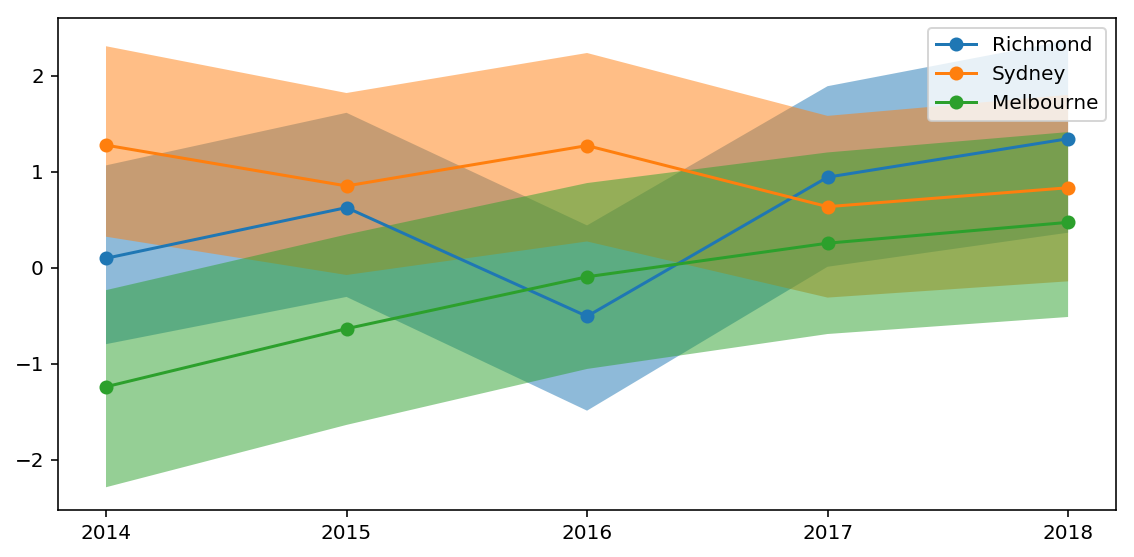

In [28]:
from datetime import datetime

# Look at some teams
teams = ['Richmond', 'Sydney', 'Melbourne']

team_ids = encoder.transform(teams)

years = (np.arange(season.max()) + data['Date'].dt.year.min()).astype(str)

for cur_team, cur_id in zip(teams, team_ids):
    
    cur_skills = skills[:, :, cur_id]
    mean = np.mean(cur_skills, axis=0)
    lower = np.percentile(cur_skills, 2.5, axis=0)
    upper = np.percentile(cur_skills, 97.5, axis=0)
    
    plt.plot(years, mean, label=cur_team, marker='o')
    plt.fill_between(years, lower, upper, alpha=0.5)
    
plt.legend()
plt.gcf().set_size_inches(8, 4)
plt.gcf().tight_layout()

In [29]:
mean_skills_overall = skills.mean(axis=0)
mean_skills_overall = pd.DataFrame(mean_skills_overall, index=years, columns=encoder.classes_)

In [30]:
mean_skills_overall.T.round(2)

,2014,2015,2016,2017,2018
Adelaide,-0.06,0.47,0.94,0.84,0.11
Brisbane,-0.54,-1.25,-1.47,-0.94,-0.92
Carlton,-0.65,-1.38,-0.82,-0.85,-1.82
Collingwood,0.02,-0.27,-0.35,-0.23,0.57
Essendon,0.21,-0.84,-1.59,0.04,0.18
Fremantle,0.76,1.14,-1.33,-0.56,-0.50
GWS Giants,-1.05,-0.21,0.92,0.71,0.54
Geelong,0.90,0.18,1.04,0.60,0.30
Gold Coast,-0.21,-1.28,-1.07,-0.96,-1.35
Hawthorn,1.44,1.15,0.98,-0.11,0.60


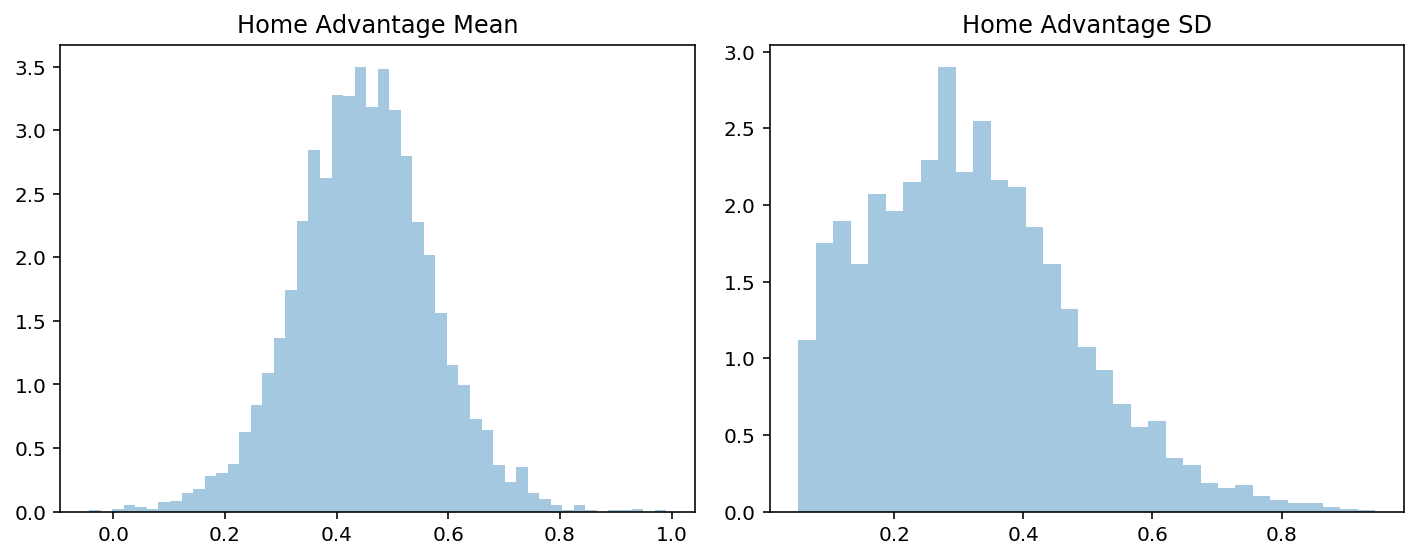

In [21]:
f, ax = plt.subplots(1, 2)

mean_home = fit.extract()['home_ad_mean']
sns.distplot(mean_home, ax=ax[0], kde=False, norm_hist=True)
sns.distplot(fit.extract()['home_ad_var'], ax=ax[1], kde=False, norm_hist=True)

f.set_size_inches(10, 4)

ax[0].set_title('Home Advantage Mean')
ax[1].set_title('Home Advantage SD')

f.tight_layout()

plt.savefig('../talks/august_2018_example_models/mean_var_home_ad.png', dpi=300)

In [22]:
p_all_same = np.mean(fit.extract()['home_ad_var'] < 1e-2)
p_all_same

0.0

In [23]:
mean_home.mean(), fit.extract()['home_ad_var'].mean()

(0.4482299607765608, 0.3187410575817976)

In [24]:
from scipy.special import expit

expit(0.4)

0.598687660112452